<a href="https://colab.research.google.com/github/anelglvz/Working-Analyst/blob/main/Matem%C3%A1ticas_CD/GWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Geographically weighted regression model

In [ ]:
!pip install -U mgwr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 KB 20.2 MB/s eta 0:00:00
  Created wheel for mgwr: filename=mgwr-2.1.2-py3-none-any.whl size=46384 sha256=4d64e165d0ad0b91b8e9d3aedc174da5c966b495eff42a846ce220f19b04613d
  Stored in directory: /root/.cache/pip/wheels/4f/26/fd/e19240ca6fc7c57f7e3a95410047f61587d261c5c52abfcf70
  Created wheel for spglm: filename=spglm-1.0.8-py3-none-any.whl size=38806 sha256=13e6aa3a52ffbc89ee3ed185971d3ab3297015096a5c73865ddc73ef14f68b10
  Stored in directory: /root/.cache/pip/wheels/04/56/0d/aaa8d7c0dedde9ad7cdb5882229ed287aacd78b1e648b5b7a1
Successfully built mgwr spglm


In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.9 MB/s eta 0:00:00


Dependencias

In [ ]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian, Binomial, Poisson

import geopandas as gpd
from shapely.geometry import Point 

import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.special import loggamma

Para información sobre `mgwr.gwr` consultar:

https://buildmedia.readthedocs.org/media/pdf/mgwr/latest/mgwr.pdf

##Data

Para mas detalle de los datos consultar: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5780421/

In [ ]:
#import data from file
url = 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5780421/bin/41598_2018_19772_MOESM3_ESM.xlsx'
data = pd.read_excel(url)
print(data.shape)
data.head()

(593, 9)


,Number of positive case,Total number of sample,Latitude,Longitude,Time index,Intercept,Temperature,Precipitation,Relative humidity
0,0,136,46.12,14.82,22,1,9.8,133.0,0.833607
1,0,143,46.12,14.82,23,1,2.9,1.0,0.917059
2,3,185,46.12,14.82,24,1,1.9,56.7,0.856400
3,27,170,46.12,14.82,25,1,0.8,26.5,0.679756
4,135,283,46.12,14.82,26,1,-2.5,35.4,0.767403


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of positive case  593 non-null    int64  
 1   Total number of sample   593 non-null    int64  
 2   Latitude                 593 non-null    float64
 3   Longitude                593 non-null    float64
 4   Time index               593 non-null    int64  
 5   Intercept                593 non-null    int64  
 6   Temperature              593 non-null    float64
 7   Precipitation            593 non-null    float64
 8   Relative humidity        593 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 41.8 KB


In [ ]:
g_y = data['Number of positive case'].values.reshape(-1,1)
print(g_y.shape)

g_X = data[['Temperature','Precipitation']].values
print(g_X.shape)

g_N = data['Total number of sample'].values

u = data['Latitude']
v = data['Longitude']
g_coords = np.array(list(zip(u, v)))
print(g_coords.shape)

(593, 1)
(593, 2)
(593, 2)


In [ ]:
location = data[['Latitude','Longitude']].drop_duplicates(subset=['Latitude','Longitude'])
#number of locations
num_location = location.shape[0]
print(num_location)
#add main key to location table
location['index']=range(num_location)
print(location)

22
     Latitude  Longitude  index
0       46.12      14.82      0
30      48.67      19.50      1
60      52.00      20.00      2
90      47.33      13.33      3
120     50.83       4.00      4
147     44.00      18.00      5
162     51.00       9.00      6
192     46.00       2.00      7
222     52.50       5.75      8
252     49.75      15.50      9
275     45.17      15.50     10
297     49.75       6.17     11
319     46.00      25.00     12
346     47.00      20.00     13
368     42.83      12.83     14
385     54.00      -2.00     15
415     13.00     105.00     16
445     18.00     105.00     17
475     15.00     100.00     18
505      1.37     103.80     19
533     16.17     107.83     20
563      2.50     112.50     21


In [ ]:
lat = location['Latitude']
lon = location['Longitude']
loc = np.array(list(zip(lat, lon)))
loc

array([[ 46.12,  14.82],
       [ 48.67,  19.5 ],
       [ 52.  ,  20.  ],
       [ 47.33,  13.33],
       [ 50.83,   4.  ],
       [ 44.  ,  18.  ],
       [ 51.  ,   9.  ],
       [ 46.  ,   2.  ],
       [ 52.5 ,   5.75],
       [ 49.75,  15.5 ],
       [ 45.17,  15.5 ],
       [ 49.75,   6.17],
       [ 46.  ,  25.  ],
       [ 47.  ,  20.  ],
       [ 42.83,  12.83],
       [ 54.  ,  -2.  ],
       [ 13.  , 105.  ],
       [ 18.  , 105.  ],
       [ 15.  , 100.  ],
       [  1.37, 103.8 ],
       [ 16.17, 107.83],
       [  2.5 , 112.5 ]])

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(-25.0, 150.0)

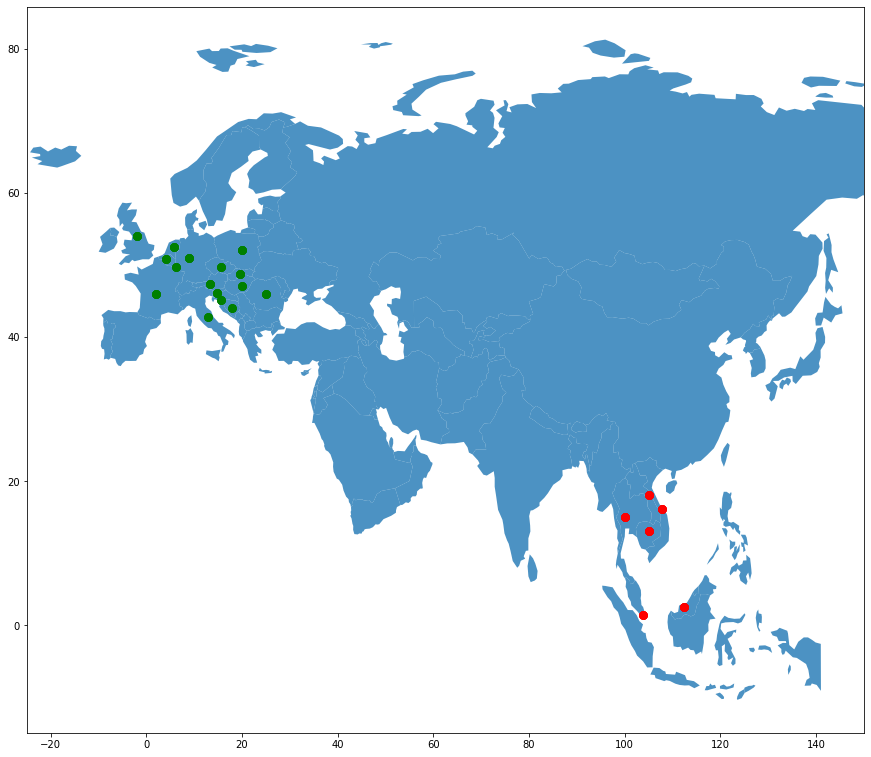

In [ ]:
geometry = [Point(xy) for xy in zip(data['Longitude'],data['Latitude'])]
crs = {'init' : 'epsg:4326'}
geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
conts = world.loc[world.continent.isin(['Asia','Europe'])]
boundaries = conts['geometry']

fig , ax = plt.subplots(figsize=(15,15))
boundaries.plot(ax=ax, alpha=0.8)
geo_df[geo_df['Longitude'] > 90 ].plot(ax=ax, marker='o', color='red', markersize=50);
geo_df[geo_df['Longitude'] <= 90 ].plot(ax=ax, marker='o', color='green', markersize=50);
plt.xlim(-25,150)


## Geographically Weighted Regression (GWR)

Seleccionamos el Bandwidth: 

Kernels disponibles:

*  Gaussian: kernel=‘gaussian’ (default)
*  Exponential: kernel=‘exponential’
*  Bi-square: kernel=‘bisquare’


Criterios disponibles:
*   Cross-validation: criterion=‘CV’
*   Akaike information criterion: criterion = ‘AIC’
*   Corrected AIC: criterion = ‘AICc’ (default)
*   Bayesian information criterion: criterion = ‘BIC’




In [ ]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)
sel = gwr_selector.search()
sel

72.0

In [ ]:
model = GWR(g_coords, g_y, g_X, sel)
gwr_results = model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 593
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       82092440.034
Log-likelihood:                                                   -4351.446
AIC:                                                               8708.891
AICc:                                                              8710.959
BIC:                                                           82088672.770
R2:                                                                   0.049
Adj. R2:                                                              0.046

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
gwr_results.params

array([[ 1.10150412e+02, -6.25908141e+00,  1.07791597e-01],
       [ 1.10150412e+02, -6.25908141e+00,  1.07791597e-01],
       [ 1.10150412e+02, -6.25908141e+00,  1.07791597e-01],
       ...,
       [-6.36573667e+02,  2.39994837e+01,  8.93629396e-02],
       [-6.36573667e+02,  2.39994837e+01,  8.93629396e-02],
       [-6.36573667e+02,  2.39994837e+01,  8.93629396e-02]])

Predicciones

In [ ]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(g_coords, g_X, scale, residuals)

In [ ]:
pred_results.predictions[:50]

array([[ 63.14769633],
       [ 92.10686723],
       [104.3699406 ],
       [107.99962392],
       [129.61393779],
       [ 58.39334401],
       [ 56.84979954],
       [ 31.5281976 ],
       [  0.3736365 ],
       [ -8.40057351],
       [-18.85922595],
       [ 24.79124878],
       [ 59.92833796],
       [ 77.55507961],
       [118.57036922],
       [118.89015963],
       [125.20889786],
       [107.44489464],
       [ 49.22391548],
       [ 44.10458349],
       [  8.24598148],
       [-21.4138868 ],
       [ -7.90329841],
       [ 30.48118536],
       [ 41.82152626],
       [ 95.88968742],
       [103.54137906],
       [101.65433523],
       [102.68555018],
       [ 59.78242186],
       [ 24.04991285],
       [ 39.74375563],
       [ 45.83881866],
       [ 53.55261361],
       [ 61.62978936],
       [ 30.70889634],
       [ 22.82597644],
       [  7.71685931],
       [  8.37121003],
       [  4.58363053],
       [ -5.32918956],
       [  6.40506495],
       [ 29.24167509],
       [ 31

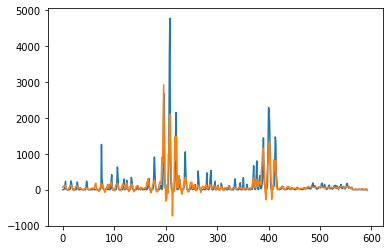

In [ ]:
plt.plot(range(len(g_y)),g_y)
plt.plot(range(len(g_y)),pred_results.predictions)
plt.show()

## Caso Poisson

In [ ]:
gwr_selector = Sel_BW(g_coords, g_y, g_X, family = Poisson())
sel = gwr_selector.search()
sel

48.0

In [ ]:
model = GWR(g_coords, g_y, g_X, sel, family = Poisson())
gwr_results = model.fit()
gwr_results.summary()

Model type                                                          Poisson
Number of observations:                                                 593
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                        195595.276
Log-likelihood:                                                  -99080.263
AIC:                                                             198166.527
AICc:                                                            195601.317
BIC:                                                             191828.011
Percent deviance explained:                                           0.161
Adj. percent deviance explained:                                      0.158

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
gwr_results.params

array([[ 4.61371287e+00, -1.44906139e-01,  1.84538841e-03],
       [ 4.61371287e+00, -1.44906139e-01,  1.84538841e-03],
       [ 4.61371287e+00, -1.44906139e-01,  1.84538841e-03],
       ...,
       [ 2.94599603e+01, -1.09589410e+00,  8.67180408e-04],
       [ 2.94599603e+01, -1.09589410e+00,  8.67180408e-04],
       [ 2.94599603e+01, -1.09589410e+00,  8.67180408e-04]])

Predicciones

In [ ]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(g_coords, g_X, scale, residuals)

In [ ]:
pred_results.predictions[:50]

array([[ 3.43906936],
       [ 4.19533045],
       [ 4.44302473],
       [ 4.54669075],
       [ 5.04130497],
       [ 3.41052625],
       [ 3.31614923],
       [ 2.70521514],
       [ 1.98687081],
       [ 1.78003031],
       [ 1.58587819],
       [ 2.53325249],
       [ 3.34620318],
       [ 3.77632538],
       [ 4.76541243],
       [ 4.75201179],
       [ 4.87151363],
       [ 4.45414186],
       [ 3.15916875],
       [ 2.9620484 ],
       [ 2.19714685],
       [ 1.54214249],
       [ 1.79609382],
       [ 2.67974015],
       [ 2.99091413],
       [ 4.14306447],
       [ 4.43638996],
       [ 4.34368242],
       [ 4.34246135],
       [ 3.42675704],
       [ 1.82025312],
       [ 2.36787545],
       [ 3.52002742],
       [ 4.05033692],
       [ 4.11914673],
       [ 1.91921323],
       [ 1.95339739],
       [ 0.82043199],
       [ 1.97136668],
       [ 1.95127312],
       [-0.121372  ],
       [ 0.83755788],
       [ 3.13302238],
       [ 2.39396011],
       [ 4.07628232],
       [ 4

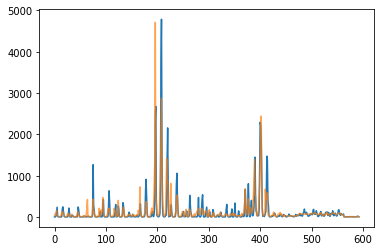

In [ ]:
plt.plot(range(len(g_y)),g_y)
plt.plot(range(len(g_y)),np.exp(pred_results.predictions), alpha=0.7)
plt.show()

## Caso Binomial

In [ ]:
gwr_selector = Sel_BW(g_coords, g_y, g_X, family = Binomial())
sel = gwr_selector.search()
sel

229.0

In [ ]:
model = GWR(g_coords, g_y, g_X, sel, family = Binomial())
gwr_results = model.fit()
gwr_results.summary()

Model type                                                         Binomial
Number of observations:                                                 593
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                          2030.475
Log-likelihood:                                                  116192.427
AIC:                                                            -232378.854
AICc:                                                              2036.515
BIC:                                                              -1736.790
Percent deviance explained:                                          -0.018
Adj. percent deviance explained:                                     -0.022

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
gwr_results.params

array([[ 2.48085649e+00, -1.57234910e-01, -3.90216461e-03],
       [ 2.48085649e+00, -1.57234910e-01, -3.90216461e-03],
       [ 2.48085649e+00, -1.57234910e-01, -3.90216461e-03],
       ...,
       [ 6.89676279e+00, -1.35394681e-01, -2.07848744e-04],
       [ 6.89676279e+00, -1.35394681e-01, -2.07848744e-04],
       [ 6.89676279e+00, -1.35394681e-01, -2.07848744e-04]])

Predicciones

In [ ]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(g_coords, g_X, scale, residuals)

In [ ]:
pred_results.predictions[:50]

array([[ 0.42096647],
       [ 2.02097308],
       [ 1.96085743],
       [ 2.2516612 ],
       [ 2.73580714],
       [ 1.13042679],
       [ 0.4954287 ],
       [-0.39185763],
       [-1.14474895],
       [-1.40284365],
       [-1.17775787],
       [-0.72370324],
       [ 0.15369052],
       [ 0.8205726 ],
       [ 2.25280952],
       [ 2.0493228 ],
       [ 1.93572409],
       [ 1.42733901],
       [ 0.50281942],
       [-0.42493352],
       [-0.66209583],
       [-1.08527657],
       [-1.34408152],
       [-0.43071872],
       [ 0.34859141],
       [ 0.69418925],
       [ 2.06761618],
       [ 1.52181712],
       [ 1.29257611],
       [ 1.00337678],
       [ 0.70764485],
       [ 1.29118945],
       [ 1.31716421],
       [ 1.54820971],
       [ 1.89404515],
       [ 0.98373825],
       [ 0.62457549],
       [ 0.19215203],
       [-0.02446449],
       [-0.18923492],
       [-0.18901395],
       [ 0.12994101],
       [ 0.65899426],
       [ 0.93184409],
       [ 1.64269032],
       [ 1

In [ ]:
def inv_logit(p):
  return np.exp(p) / (1 + np.exp(p))

In [ ]:
p = inv_logit(pred_results.predictions).reshape(1,-1)
p

array([[0.6037145 , 0.88298159, 0.87662572, 0.90479373, 0.93910677,
        0.75591765, 0.62138446, 0.40327019, 0.24144952, 0.19736525,
        0.23545558, 0.32657803, 0.53834718, 0.69435787, 0.9048926 ,
        0.88587917, 0.87388164, 0.80648636, 0.62312168, 0.39533681,
        0.34026897, 0.25250877, 0.20683966, 0.39395472, 0.58627596,
        0.6668982 , 0.88771557, 0.8208059 , 0.7845829 , 0.73172197,
        0.66988055, 0.78434845, 0.78870952, 0.82465501, 0.86921607,
        0.72784934, 0.65125846, 0.54789074, 0.49388418, 0.45283194,
        0.45288669, 0.53243962, 0.65903443, 0.71744926, 0.83790068,
        0.83713709, 0.80951824, 0.79630476, 0.64931714, 0.57355267,
        0.50502075, 0.45143957, 0.44878525, 0.59244642, 0.62614529,
        0.72563858, 0.79803832, 0.79212698, 0.76094535, 0.69284321,
        0.6827038 , 0.77361152, 0.80736231, 0.86205583, 0.90289508,
        0.74739116, 0.68985215, 0.55771614, 0.56537453, 0.47964698,
        0.47507219, 0.55218478, 0.70863127, 0.76

In [ ]:
g_y[200:220]

array([[  18],
       [   9],
       [   0],
       [   8],
       [  23],
       [  83],
       [ 741],
       [3619],
       [4782],
       [1561],
       [ 248],
       [  31],
       [   6],
       [   1],
       [   1],
       [   7],
       [  41],
       [  42],
       [ 258],
       [1399]])

In [ ]:
g_N[200:220]

array([ 3361,  2023,  1676,  2261,  4679,  8239, 10106, 15565, 16281,
        9997,  5342,  3856,  2908,  2390,  1836,  3215,  6252,  6008,
        8995, 13926])

In [ ]:
p[0][200:220]

array([0.71002114, 0.71175749, 0.69102186, 0.78476991, 0.77844602,
       0.9082035 , 0.9155867 , 0.95159128, 0.9664736 , 0.93632154,
       0.89162291, 0.82405871, 0.78969161, 0.59950613, 0.72006349,
       0.76526962, 0.77574756, 0.8991665 , 0.94138202, 0.90250176])

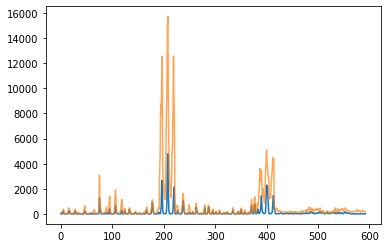

In [ ]:
plt.plot(range(len(g_y)),g_y)
plt.plot(range(len(g_y)),p[0]*g_N, alpha=0.7)
plt.show()

## Multiscale Geographically Weighted Regression (MGWR)

Necesitamos estandarizar los datos

In [ ]:
sel2 = Sel_BW(g_coords, g_y, g_X, multi=True)
sel2.search(multi_bw_min=[2])

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

array([55., 55., 73.])

In [ ]:
model2 = MGWR(g_coords, g_y, g_X, sel2)
gwr_results2 = model2.fit()
gwr_results2.summary()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 593
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       82092440.034
Log-likelihood:                                                   -4351.446
AIC:                                                               8708.891
AICc:                                                              8710.959
BIC:                                                           82088672.770
R2:                                                                   0.049
Adj. R2:                                                              0.046

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

/usr/local/lib/python3.8/dist-packages/mgwr/gwr.py:1548: RuntimeWarning: invalid value encountered in true_divide
  CCT[:, j] += ((pR[:, :, j] / self.X[:, j].reshape(-1, 1))**2).sum(


In [ ]:
gwr_results2.params

array([[ 1.11905332e+02, -6.54848874e+00,  8.93439101e-02],
       [ 1.11905332e+02, -6.54848874e+00,  8.93439101e-02],
       [ 1.11905332e+02, -6.54848874e+00,  8.93439101e-02],
       ...,
       [-6.13254716e+02,  2.28571989e+01,  8.52381162e-02],
       [-6.13254716e+02,  2.28571989e+01,  8.52381162e-02],
       [-6.13254716e+02,  2.28571989e+01,  8.52381162e-02]])

In [ ]:
params2 = pd.DataFrame(gwr_results2.params).drop_duplicates().values
params2

array([[ 1.11905332e+02, -6.54848874e+00,  8.93439101e-02],
       [ 4.31814237e+01, -2.62777285e+00,  3.98055257e-02],
       [ 1.35776684e+02, -1.19136154e+01,  5.26806862e-01],
       [ 1.73852382e+02, -1.12275154e+01, -9.14043630e-02],
       [ 2.11135390e+02, -1.11691746e+01, -7.52996303e-01],
       [ 7.32615932e+01, -5.14214259e+00,  1.53051190e-03],
       [ 2.66659574e+02, -1.51705590e+01, -6.66097603e-01],
       [ 3.25510178e+03, -1.47575331e+02, -1.17765280e+01],
       [ 4.46431541e+02, -2.44641134e+01, -1.48323254e+00],
       [ 9.89701614e+01, -9.07958576e+00,  2.32611804e-01],
       [ 1.24490817e+02, -6.25108751e+00,  1.83241231e-01],
       [ 1.38908630e+02, -9.16933506e+00, -5.64549507e-01],
       [ 6.68567282e+01, -2.93243196e+00,  1.17726813e-02],
       [ 4.77191882e+01, -2.24148128e+00, -3.70323721e-03],
       [ 5.47113744e+02, -4.05944314e+01,  2.73294445e-01],
       [ 2.16198848e+03, -1.31658959e+02, -4.12494855e+00],
       [ 2.62328795e+02, -9.04141890e+00

`MGWR.predict` is not implemented yet

In [ ]:
y_pred = g_X[:,0]*gwr_results2.params[:,1] + g_X[:,1]*gwr_results2.params[:,2] + gwr_results2.params[:,0]

In [ ]:
y_pred

array([ 5.96128825e+01,  9.30040587e+01,  1.04529003e+02,  1.09034155e+02,
        1.31439328e+02,  5.75770405e+01,  5.38485814e+01,  2.64657529e+01,
       -6.02388950e+00, -1.53373623e+01, -2.45503384e+01,  1.88408800e+01,
        5.55838921e+01,  7.48199952e+01,  1.19156400e+02,  1.18741161e+02,
        1.24386676e+02,  1.05581043e+02,  4.65753876e+01,  3.83864490e+01,
        3.22236545e+00, -2.66677891e+01, -1.46530719e+01,  2.53258086e+01,
        3.89431992e+01,  9.19216187e+01,  1.04114364e+02,  1.00373312e+02,
        1.00547743e+02,  5.84562685e+01,  2.51967674e+01,  4.29664130e+01,
        4.52313475e+01,  5.26766836e+01,  6.28735546e+01,  3.33948537e+01,
        2.29431057e+01,  8.82490382e+00,  3.99858882e+00, -8.43040236e-01,
       -3.54547053e+00,  7.02918809e+00,  2.54907201e+01,  3.24987428e+01,
        5.54717613e+01,  5.63433199e+01,  4.97382452e+01,  4.74447779e+01,
        2.21987423e+01,  1.42827279e+01,  5.61499724e+00, -3.60125909e+00,
       -3.17552241e+00,  

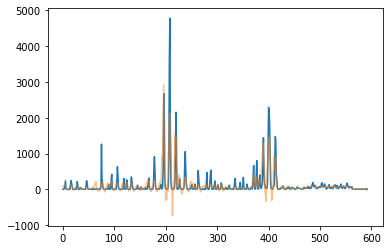

In [ ]:
plt.plot(range(len(g_y)),g_y)
plt.plot(range(len(g_y)),y_pred, alpha=0.5)
plt.show()

# Estimadores Bayesianos

La media es $m=exp(\phi_0+\phi_1 x_1 + \phi_2 x_2)$ y $r = \theta^{-1}$

Queremos una muestra de $P(\phi_0,\phi_1,\phi_2,\theta \mid Y)$

In [ ]:
task_id = 4
is_eucliDis = False      #Using Euclidian distance?
is_block = False        #block sampling?

In [ ]:
#geographical kernel bandwidth
h = [100,500,1000,2000,3000,5000,7000,10000,20000][task_id]

In [ ]:
#Geographically weighted kernel (exponential kernel)
def G_kernel(d,h):
    return(np.exp(-d**2/h**2))
    
#euclidean distance
def eucliDis(A,B):
    A = np.array(A)
    B = np.array(B)
    return np.sqrt(sum((A-B)**2))

#spherical distance (measured in KM)
def Haversine(A,B):
    """
    This uses the ‘haversine’ formula to calculate the great-circle distance between two points – that is, 
    the shortest distance over the earth’s surface – giving an ‘as-the-crow-flies’ distance between the points 
    (ignoring any hills they fly over, of course!).
    Haversine
    formula:    a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    c = 2 ⋅ atan2( √a, √(1−a) )
    d = R ⋅ c
    where   φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km);
    note that angles need to be in radians to pass to trig functions!
    """
    lat1,lon1,lat2,lon2 = A[0],A[1],B[0],B[1]
    
    R = 6378.0088
    lat1,lon1,lat2,lon2 = map(np.radians, [lat1,lon1,lat2,lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2) **2
    c = 2 * np.arctan2(a**0.5, (1-a)**0.5)
    d = R * c
    return round(d,4)

In [ ]:
#log-likelihood of negative binomial distribution
def negBion(outcome,offset,covariate,phi,theta):
    mean = np.exp(np.log(offset)+sum(np.array(covariate)*np.array(phi)))
    result = loggamma(outcome+1/theta)-loggamma(1/theta)-loggamma(outcome+1)-(1/theta)*np.log(1+theta*mean)+outcome*np.log(theta*mean/(1+theta*mean))
    return result

#log-prior for phi (uniform) 
def prior_phi(phi):
    if max(abs(np.array(phi)))>1000:
        return np.log(0)
    else:
        return np.log(1/2000)*len(phi)
    
#log-prior for theta (uniform 0,1000)
def prior_theta(theta):
    if theta>1000 or theta<=0:
        return np.log(0)
    else:
        return np.log(1/1000)

In [ ]:
#baseline proposal sd for phi (proportional to estimated correlation matrix of phi)
#EURO
pro_st = np.array([[ 1,0,0],
       [0,  0.1, 0],
       [0 , 0,  0.01]])
 
#SouthEast    
pro_st2 = np.array([[ 9.93206712e-01, -3.78288045e-02, -1.04242828e-05],
       [-3.78288045e-02,  6.41566397e-03, -3.39223226e-04],
       [-1.04242828e-05, -3.39223226e-04,  3.57276820e-04]])


#two step adatpive proposal sd:
#aggressive proposal sd for phi to approximate true value before burn_in
pro_early = np.dot(pro_st,pro_st)
#mild proposal sd for phi to achieve a good mixture after burn_in
pro_later1 = [np.dot(pro_st,pro_st),np.dot(pro_st/4,pro_st/4),np.dot(pro_st/4,pro_st/4),np.dot(pro_st/4,pro_st/4),np.dot(pro_st/4,pro_st/4),np.dot(pro_st/4,pro_st/4),np.dot(pro_st2,pro_st2),np.dot(pro_st2,pro_st2),np.dot(pro_st2,pro_st2)][task_id]
pro_later2 = np.dot(pro_st2,pro_st2)

 
#aggressive proposal sd for theta to approximate true value before burn_in 
pro_theta_early = 0.25
#mild proposal sd for theta to achieve a good mixture after burn_in
pro_theta_later = 0.25


In [ ]:
#speccialized with latitude
#proposal sampling function for phi (multivariate normal)
def r_phi(phi):
    phi = np.array(phi)
    phi_n = ss.multivariate_normal(phi,pro_early).rvs(1)
    return phi_n
#proposal density function for phi
def d_phi(phi_n,phi):
    return np.log(ss.multivariate_normal(phi,pro_early).pdf(phi_n))

def r_phi_new(phi,lat):
    if(lat>20):
        phi = np.array(phi)
        phi_n = ss.multivariate_normal(phi,pro_later1).rvs(1)
        return phi_n
    else:
        phi = np.array(phi)
        phi_n = ss.multivariate_normal(phi,pro_later2).rvs(1)
        return phi_n
#proposal density function for phi
def d_phi_new(phi_n,phi,lat):
    if(lat>20):
        return np.log(ss.multivariate_normal(phi,pro_later1).pdf(phi_n))
    else:
        return np.log(ss.multivariate_normal(phi,pro_later2).pdf(phi_n))

#proposal sampling function for theta (truncated normal)
def r_theta(theta):
    lower, upper, sd = 0, 1000, pro_theta_early
    X = ss.truncnorm(
          (lower-theta)/sd,(upper-theta)/sd,loc=theta,scale=sd)
    return float(X.rvs(size=1))
#proposal density function for theta
def d_theta(theta_n,theta):
    theta_n = np.array(theta_n)
    theta = np.array(theta)
    lower, upper, sd = 0, 1000, pro_theta_early
    X = ss.truncnorm(
          (lower-theta)/sd,(upper-theta)/sd,loc=theta,scale=sd)
    return sum(np.log(X.pdf(theta_n)))


In [ ]:
#import data from file
url = 'https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5780421/bin/41598_2018_19772_MOESM3_ESM.xlsx'
data = pd.read_excel(url)
#extract coordinates of locations
location = data[['Latitude','Longitude']].drop_duplicates(subset=['Latitude','Longitude'])
#number of locations
num_location = location.shape[0]
#add main key to location table
location['index']=range(num_location)

In [ ]:
#given a observation (data_slice) and a location of interest (loc_int), this function calculate the geographical weight
def kernel_weight(data,loc_int,h):
    loc1=data[['Latitude','Longitude']].values
    if(is_eucliDis == True):
        dis = np.array([eucliDis(x,loc_int) for x in loc1])
    else:
        dis = np.array([Haversine(x,loc_int) for x in loc1])
    kern = G_kernel(dis,h)
    return(kern)

#geographical weighting kernel matrix
theta_rep_num = np.zeros(shape=[num_location,num_location])
theta_slice_ind = np.zeros(shape=[num_location,(num_location+1)])


for i in range(num_location):
    loc_int_inner = location.values[i][0:2]
    for j in range(num_location):
        theta_rep_num[i][j] = np.equal(data.iloc[:,2:4].values, location[['Latitude','Longitude']].values[j]).all(axis=1).sum()
    theta_slice_ind[i] = np.append(0,[sum(theta_rep_num[i][:(k+1)]) for k in range(len(theta_rep_num[i]))])

theta_slice_ind = theta_slice_ind.astype(int)        

In [ ]:
def joint_like(data,loc_int,phi,theta):
    loc_ind = int(location.loc[(location['Latitude']==loc_int[0]) & (location['Longitude']==loc_int[1])]['index'])
    theta_expand = np.repeat(np.array(theta),theta_rep_num[loc_ind].astype(int))   
    outcome = np.array(data['Number of positive case'])
    offset = np.array(data['Total number of sample'])
    covariate = np.array(data[['Intercept','Temperature','Precipitation']])
    mean = np.exp(np.log(offset) + np.array(list(map(sum,covariate*np.array(phi)))))
    result = sum(kernel_weight(data,loc_int,h)*(loggamma(outcome+1/theta_expand)-loggamma(1/theta_expand)-loggamma(outcome+1)-(1/theta_expand)*np.log(1+theta_expand*mean)+outcome*np.log(theta_expand*mean/(1+theta_expand*mean))))
    result += (prior_phi(phi) + sum(list(map(prior_theta, theta))))
    return(result)

def theta_like(subdata,loc_int,phi,theta):
    loc_ind = int(location.loc[(location['Latitude']==loc_int[0]) & (location['Longitude']==loc_int[1])]['index'])
    theta_expand = np.repeat(np.array(theta),theta_rep_num[loc_ind].astype(int))   
    outcome = np.array(subdata['Number of positive case'])
    offset = np.array(subdata['Total number of sample'])
    covariate = np.array(subdata[['Intercept','Temperature','Precipitation']])
    mean = np.exp(np.log(offset) + np.array(list(map(sum,covariate*np.array(phi)))))
    theta_like_value = kernel_weight(data,loc_int,h)*(loggamma(outcome+1/theta_expand)-loggamma(1/theta_expand)-loggamma(outcome+1)-(1/theta_expand)*np.log(1+theta_expand*mean)+outcome*np.log(theta_expand*mean/(1+theta_expand*mean)))
    result = np.array([sum(theta_like_value[theta_slice_ind[loc_ind][k]:theta_slice_ind[loc_ind][k+1]]) for k in range(num_location)])
    result += np.array(list(map(prior_theta, theta)))
    return(result)

Metropolis Hastings

In [ ]:
#Given necessary model information "model_info" (i.e., list of value of phi, value of theta, coordinates of location of interest, joint density, value of theta at location of interest, number of accepted proposals),
#function "GWR_update" updates old "model_info" by one step metropolis hasting. The output is new "model_info".
if is_block:
    def GWR_update(model_info):
        phi_old = model_info[0]
        theta_old = model_info[1]
        loc_int = model_info[2]
        joint_old = model_info[3]
        accept_num = model_info[5]
        theta_focus = int(location.loc[(location['Latitude']==loc_int[0]) & (location['Longitude']==loc_int[1])]['index'])
        phi_new = r_phi(phi_old)
        theta_new = list(map(r_theta,theta_old))
        joint_new_phi = joint_like(data,loc_int,phi_new,theta_old)
        rate_phi = joint_new_phi + d_phi(phi_old,phi_new) - joint_old - d_phi(phi_new,phi_old) 
        alfa_phi = min(1,np.exp(rate_phi))
        runif = np.random.uniform(0,1,1)[0]
        phi_old = phi_new if runif < alfa_phi else phi_old
        accept_num = (accept_num + 1) if runif <alfa_phi else accept_num
        joint_new_theta = theta_like(data,loc_int,phi_old,theta_new)
        joint_old_theta = theta_like(data,loc_int,phi_old,theta_old)
        rate_theta = joint_new_theta + d_theta(theta_old,theta_new) - joint_old_theta - d_theta(theta_new,theta_old)
        alfa_theta = np.minimum(np.ones_like(rate_theta),np.exp(rate_theta))
        runif = np.random.uniform(0,1,len(alfa_theta))
        theta_pro = [theta_new[q] if runif[q] < alfa_theta[q] else theta_old[q] for q in range(num_location)]
        theta_old = theta_pro
        sto_theta = theta_old[theta_focus]
        joint_old = joint_like(data,loc_int,phi_old,theta_old)
        return([list(phi_old),theta_old,loc_int,joint_old,sto_theta,accept_num])
else:
    def GWR_update(model_info):
        phi_old = model_info[0]
        theta_old = model_info[1]
        loc_int = model_info[2]
        joint_old = model_info[3]
        accept_num = model_info[5]
        theta_focus = int(location.loc[(location['Latitude']==loc_int[0]) & (location['Longitude']==loc_int[1])]['index'])
        phi_new = r_phi(phi_old)
        theta_new = list(map(r_theta,theta_old))
        joint_new = joint_like(data,loc_int,phi_new,theta_new)
        rate = joint_new + d_phi(phi_old,phi_new) + d_theta(theta_old,theta_new) - joint_old - d_phi(phi_new,phi_old) - d_theta(theta_new,theta_old)
        alfa = min(1,np.exp(rate))
        runif = np.random.uniform(0,1,1)[0]
        phi_old = phi_new if runif < alfa else phi_old
        theta_old = theta_new if runif <alfa else theta_old
        joint_old = joint_new if runif <alfa else joint_old
        accept_num = (accept_num + 1) if runif <alfa else accept_num
        sto_theta = theta_old[theta_focus]
        return([list(phi_old),theta_old,loc_int,joint_old,sto_theta,accept_num])


In [ ]:
#initial value "init" (list of initial phi, initial theta, coordinates of location of interest, initial joint density)    
init_phi = [1,1,1]    
init = [[init_phi,[1]*num_location,list(x),joint_like(data,x,init_phi,[1]*num_location),1,0] for x in location[['Latitude','Longitude']].values] 

In [ ]:
def GWR_update_new(model_info):
    phi_old = model_info[0]
    theta_old = model_info[1]
    loc_int = model_info[2]
    joint_old = model_info[3]
    accept_num = model_info[5]
    theta_focus = int(location.loc[(location['Latitude']==loc_int[0]) & (location['Longitude']==loc_int[1])]['index'])
    phi_new = r_phi_new(phi_old,loc_int[0])
    theta_new = list(map(r_theta,theta_old))
    joint_new_phi = joint_like(data,loc_int,phi_new,theta_old)
    rate_phi = joint_new_phi + d_phi_new(phi_old,phi_new,loc_int[0]) - joint_old - d_phi_new(phi_new,phi_old,loc_int[0]) 
    alfa_phi = min(1,np.exp(rate_phi))
    runif = np.random.uniform(0,1,1)[0]
    phi_old = phi_new if runif < alfa_phi else phi_old
    accept_num = (accept_num + 1) if runif <alfa_phi else accept_num
    joint_new_theta = theta_like(data,loc_int,phi_old,theta_new)
    joint_old_theta = theta_like(data,loc_int,phi_old,theta_old)
    rate_theta = joint_new_theta + d_theta(theta_old,theta_new) - joint_old_theta - d_theta(theta_new,theta_old)
    alfa_theta = np.minimum(np.ones_like(rate_theta),np.exp(rate_theta))
    runif = np.random.uniform(0,1,len(alfa_theta))
    theta_pro = [theta_new[q] if runif[q] < alfa_theta[q] else theta_old[q] for q in range(num_location)]
    theta_old = theta_pro
    sto_theta = theta_old[theta_focus]
    joint_old = joint_like(data,loc_int,phi_old,theta_old)
    return([list(phi_old),theta_old,loc_int,joint_old,sto_theta,accept_num])

In [ ]:
#MCMC updates of all location simultaneously
def GWR_MCMC_multloc(init,num_iter,thin,burn_in):
    sto_phi = np.zeros([(num_iter-burn_in)//thin,num_location,len(init[0][0])])     #store posterior samples of phi
    sto_theta = np.zeros([(num_iter-burn_in)//thin,num_location,1])     #store posterior samples of theta
    iter_param = init   
    for i in range(num_iter):
        if i%100 == 0:
          print(i)
        
        if( (i<=(burn_in-1)) | ((i+1) % thin !=0)):
            iter_param = list(map(GWR_update,iter_param))       #one step metropolis hasting update for all locations
            
        else:
            iter_param = list(map(GWR_update_new,iter_param))       #one step metropolis hasting update for all locations
            accept_number = []
            for j in range(num_location):       #calculate the elpd at each location by for loop
                sto_phi[((i+1-burn_in)//thin) - 1][j] = iter_param[j][0]
                sto_theta[((i+1-burn_in)//thin) - 1][j] = iter_param[j][4] 
                accept_number.append(iter_param[j][5])
    result = {'phi':sto_phi,'theta':sto_theta}
    return(result)

In [ ]:
%%time
re=GWR_MCMC_multloc(init,2000,1,1000)

0


<ipython-input-49-9877acbc2e76>:41: RuntimeWarning: overflow encountered in exp
  alfa = min(1,np.exp(rate))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
CPU times: user 51min 5s, sys: 16.7 s, total: 51min 22s
Wall time: 51min 15s


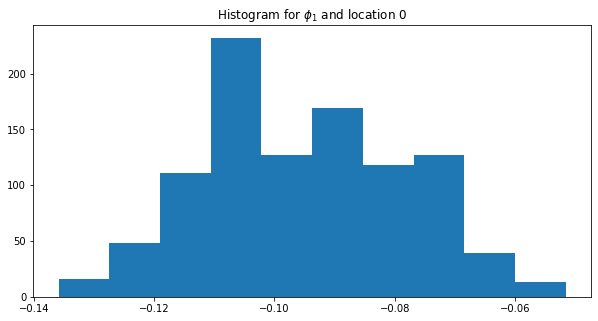

In [ ]:
#Histogram for the parameter phi_j in the location i
i = 0
j = 1
plt.figure(figsize=(10, 5))
plt.hist(re['phi'][:,i,j], label=('Location_{}').format(i))
plt.title('Histogram for '+ r'$\phi_{}$'.format(j)+' and '+r'location {}'.format(i))
plt.show()

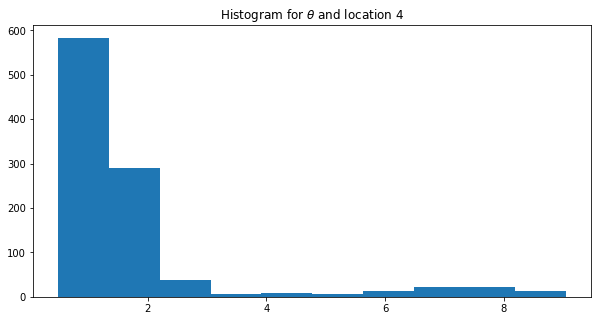

In [ ]:
# Histogram of theta for location i
i = 4
plt.figure(figsize=(10, 5))
plt.hist(re['theta'][:,i], label=('Location_{}').format(i))
plt.title('Histogram for '+ r'$\theta$'+' and '+r'location {}'.format(i))
plt.show()

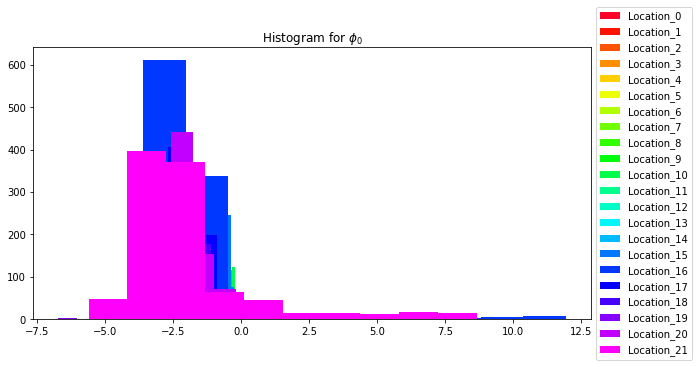

In [ ]:
#Histogram for phi_0
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/num_location) for i in range(num_location)])
for i in range(num_location):
    plt.hist(re['phi'][:,i,0], label=('Location_{}').format(i))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Histogram for '+ r'$\phi_0$')
plt.show()

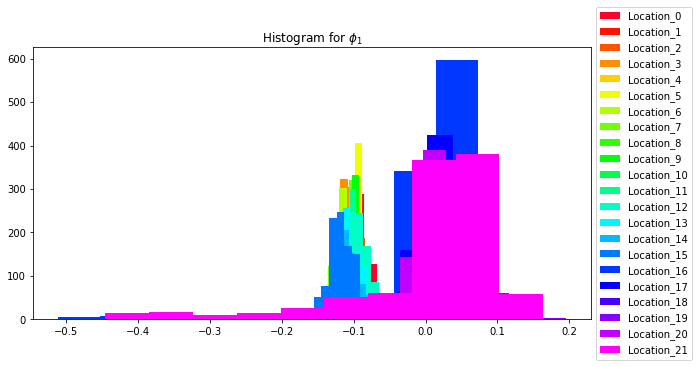

In [ ]:
#Histogram for phi_1
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/num_location) for i in range(num_location)])
for i in range(num_location):
    plt.hist(re['phi'][:,i,1], label=('Location_{}').format(i))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Histogram for '+ r'$\phi_1$')
plt.show()

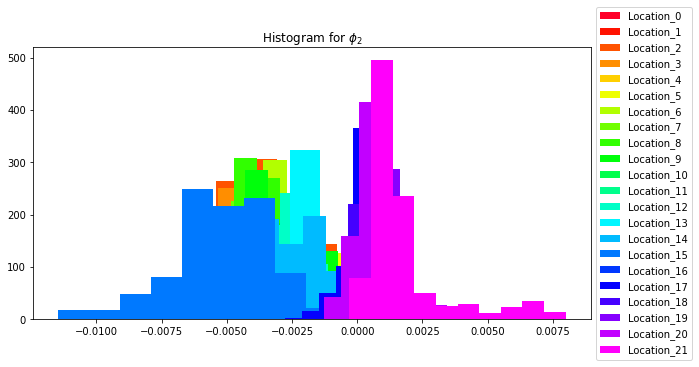

In [ ]:
#Histogram for phi_2
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/num_location) for i in range(num_location)])
for i in range(num_location):
    plt.hist(re['phi'][:,i,2], label=('Location_{}').format(i))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Histogram for '+ r'$\phi_2$')
plt.show()

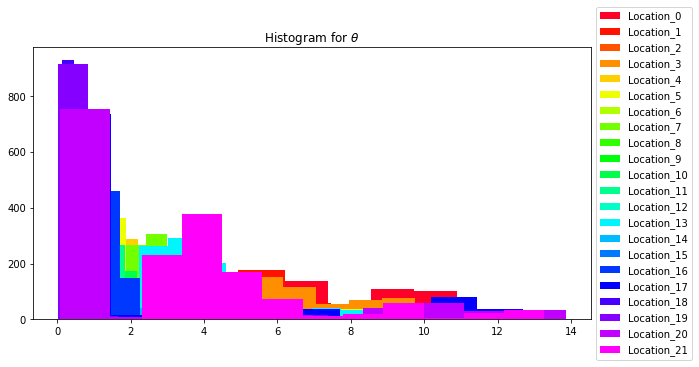

In [ ]:
#Histogram for theta
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/num_location) for i in range(num_location)])
for i in range(num_location):
    plt.hist(re['theta'][:,i], label=('Location_{}').format(i))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Histogram for '+ r'$\theta$')
plt.show()

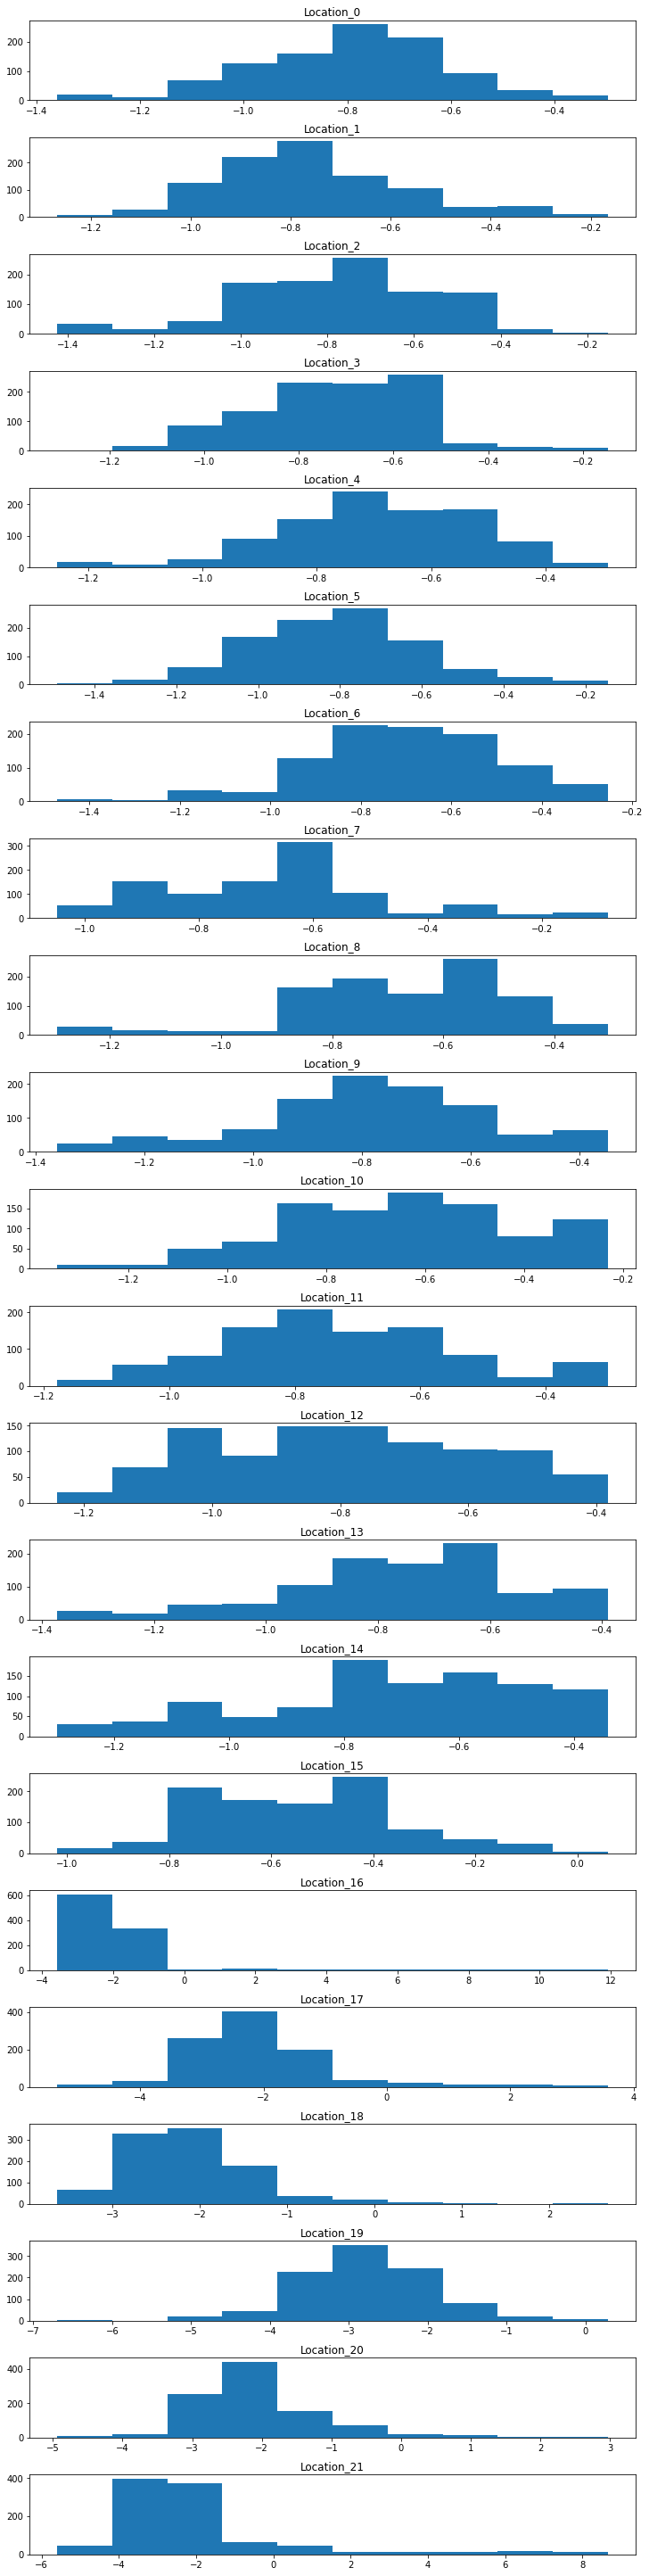

In [ ]:
# Histograms for phi_0
fig, axs = plt.subplots(22, figsize=(10,40), constrained_layout=True)

for i in range(num_location):
    axs[i].hist(re['phi'][:,i,0])
    axs[i].set_title('Location_{}'.format(i))

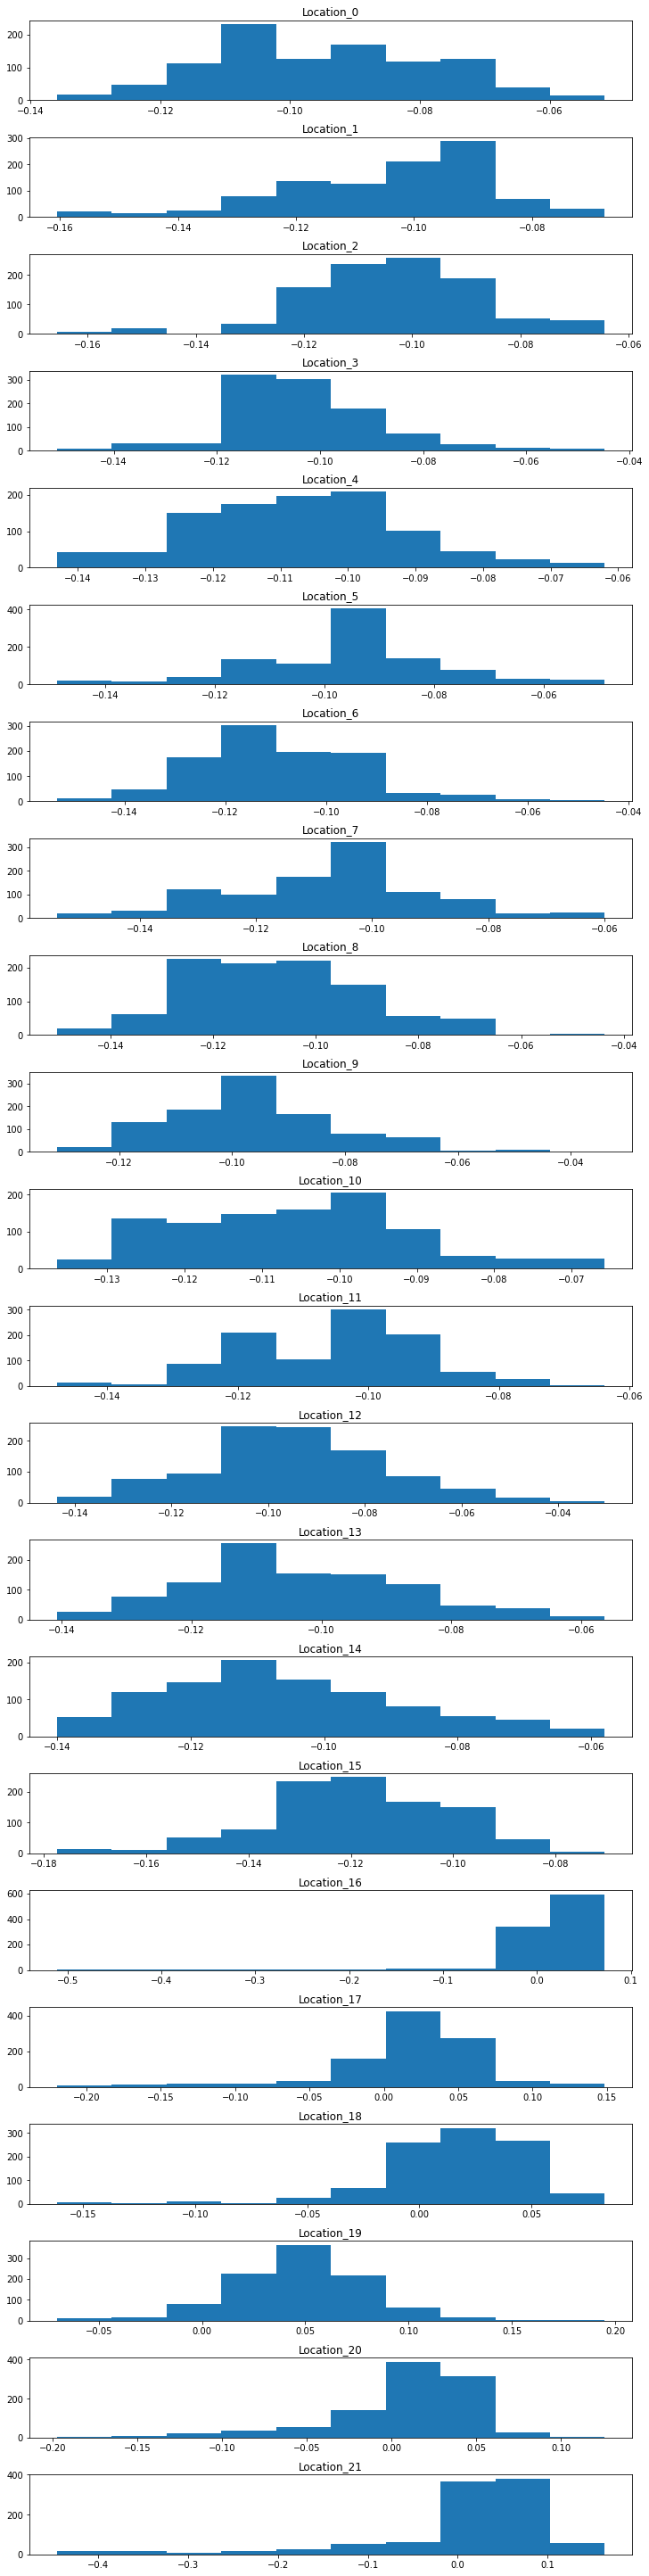

In [ ]:
# Histograms for phi_1
fig, axs = plt.subplots(22, figsize=(10,40), constrained_layout=True)

for i in range(num_location):
    axs[i].hist(re['phi'][:,i,1])
    axs[i].set_title('Location_{}'.format(i))

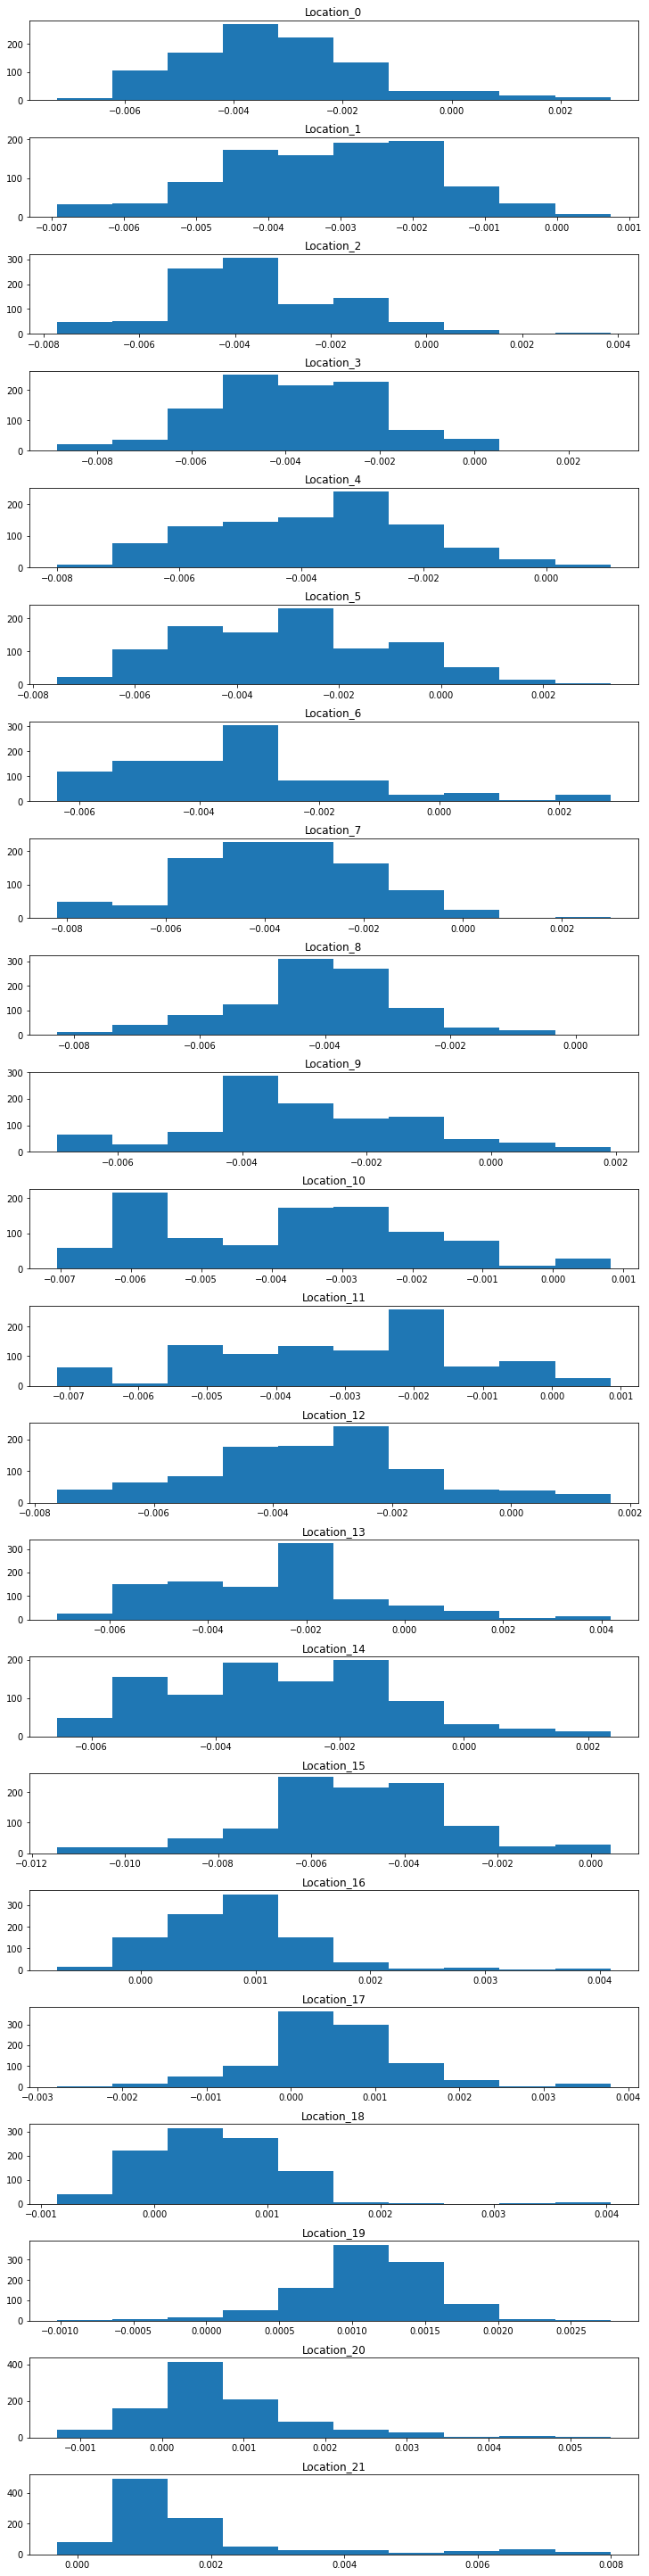

In [ ]:
# Histograms for phi_2
fig, axs = plt.subplots(22, figsize=(10,40), constrained_layout=True)

for i in range(num_location):
    axs[i].hist(re['phi'][:,i,2])
    axs[i].set_title('Location_{}'.format(i))

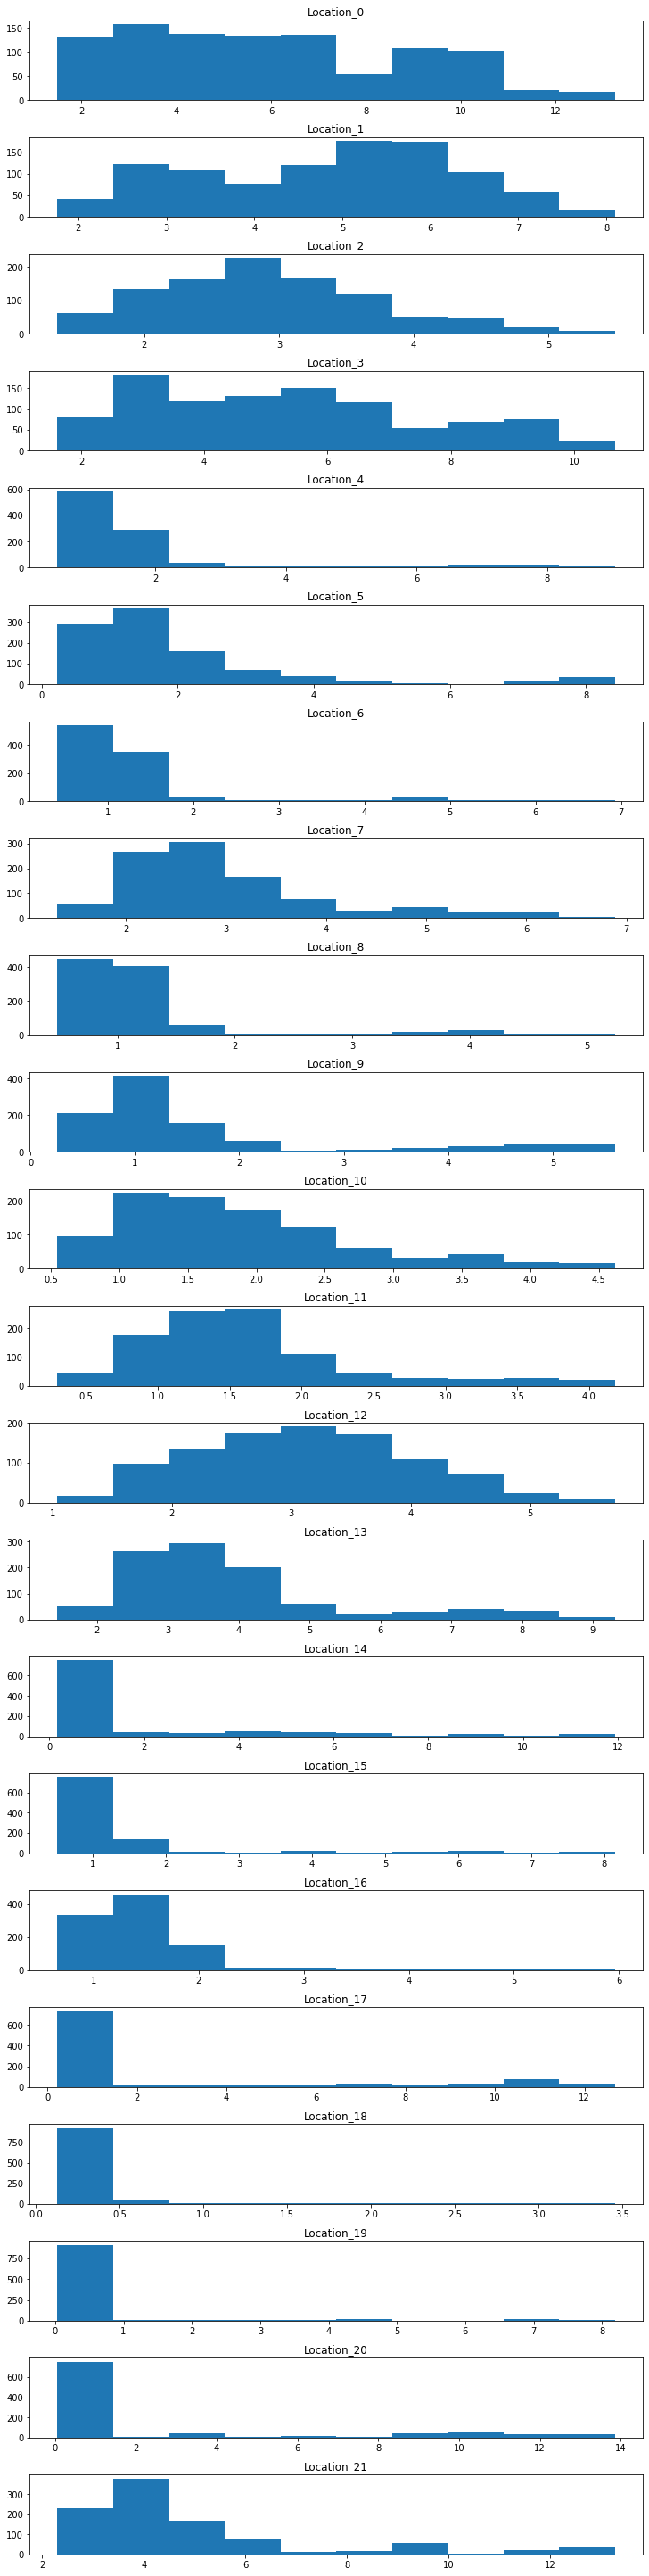

In [ ]:
# Histograms for theta
fig, axs = plt.subplots(22, figsize=(10,40), constrained_layout=True)

for i in range(num_location):
    axs[i].hist(re['theta'][:,i])
    axs[i].set_title('Location_{}'.format(i))

Para una predicción usamos la media de la binomial negativa: https://en.wikipedia.org/wiki/Negative_binomial_distribution

In [ ]:
est_phi=sum(re['phi'])/re['phi'].shape[0]       #posterior estimation of phi (posterior mean)
est_theta=sum(re['theta'])/re['theta'].shape[0]     ##posterior estimation of theta (posterior mean)


upper_phi=np.zeros_like(sum(re['phi']))
median_phi=np.zeros_like(sum(re['phi']))
lower_phi=np.zeros_like(sum(re['phi']))
for i in range(num_location):
    store_phi = []
    for j in range(re['phi'].shape[0]):
        store_phi.append(re['phi'][j][i])
    store_phi = np.array(pd.DataFrame(store_phi).T)
    upper_phi[i] = np.quantile(store_phi,q=0.975,axis=1)
    median_phi[i] = np.quantile(store_phi,q=0.5,axis=1)
    lower_phi[i] = np.quantile(store_phi,q=0.025,axis=1)

In [ ]:
s_phi = np.repeat(est_phi, list(theta_rep_num[0]), axis = 0)
s_theta = np.repeat(est_theta, list(theta_rep_num[0]), axis = 0)


offset = np.array(data['Total number of sample'])
covariate = np.array(data[['Intercept','Temperature','Precipitation']])
mean = np.exp(np.log(offset) + np.array(list(map(sum,covariate*np.array(s_phi)))))

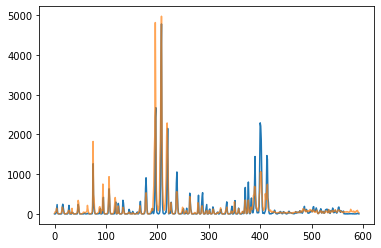

In [ ]:
plt.plot(range(data.shape[0]),data['Number of positive case'].values)
plt.plot(range(data.shape[0]),mean, alpha=0.7)
plt.show()

Referencias:

https://arxiv.org/pdf/2106.00996.pdf